In [66]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./mp'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


./mp/.DS_Store
./mp/samples/493718.png
./mp/samples/578975.png
./mp/samples/519637.png
./mp/samples/592599.png
./mp/samples/611172.png
./mp/samples/420302.png
./mp/samples/868081.png
./mp/samples/586710.png
./mp/samples/967615.png
./mp/samples/130537.png
./mp/samples/834677.png
./mp/samples/254221.png
./mp/samples/668061.png
./mp/samples/425668.png
./mp/samples/797300.png
./mp/samples/263062.png
./mp/samples/428775.png
./mp/samples/149356.png
./mp/samples/217682.png
./mp/samples/933479.png
./mp/samples/790085.png
./mp/samples/798432.png
./mp/samples/748565.png
./mp/samples/613574.png
./mp/samples/440143.png
./mp/samples/678464.png
./mp/samples/770158.png
./mp/samples/492373.png
./mp/samples/918991.png
./mp/samples/947891.png
./mp/samples/442409.png
./mp/samples/828000.png
./mp/samples/509057.png
./mp/samples/222937.png
./mp/samples/342230.png
./mp/samples/150707.png
./mp/samples/662277.png
./mp/samples/874756.png
./mp/samples/592470.png
./mp/samples/894850.png
./mp/samples/435785.png
.

# Import Libraries

In [67]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd

import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

# Load Data

In [68]:
root_dir = "./mp/samples"

In [69]:
image_paths = []
labels = []

for file in tqdm.tqdm(os.listdir(root_dir)):
    filepath = os.path.join(root_dir, file)
    label = filepath.split("/")[-1].split(".")[0]

    image_paths.append(filepath)
    labels.append(label)

100%|██████████| 132/132 [00:00<00:00, 650585.34it/s]


In [70]:
images_df = pd.DataFrame({"image_path": image_paths, "label": labels})
images_df.head()

,image_path,label
0,./mp/samples/493718.png,493718
1,./mp/samples/578975.png,578975
2,./mp/samples/519637.png,519637
3,./mp/samples/592599.png,592599
4,./mp/samples/611172.png,611172


In [71]:
characters = set(char for label in labels for char in label)
print("Characters:\n", characters)

Characters:
 {'4', '9', '1', '2', '7', '6', '5', '3', '8', '0'}


# Preprocess

In [72]:
char_to_num = layers.StringLookup(
    vocabulary = list(characters),
    num_oov_indices = 0,
    mask_token = None
)

In [73]:
pd.DataFrame({"char": char_to_num.get_vocabulary(),
              "num": np.arange(1, len(char_to_num.get_vocabulary())+1)})

,char,num
0,4,1
1,9,2
2,1,3
3,2,4
4,7,5
5,6,6
6,5,7
7,3,8
8,8,9
9,0,10


In [74]:
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [75]:
def encode_single_sample(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=1)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [50, 200])
    image = tf.transpose(image, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return image, label

In [76]:
def process_dataset(X, y):
    images = []
    labels = []
    for img_path, label in zip(X, y):
        img, lbl = encode_single_sample(img_path, label)
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.array(images), np.array(labels)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(np.array(image_paths), np.array(labels), test_size=0.10, random_state=42)

In [78]:
X_train_processed, y_train_processed = process_dataset(X_train, y_train)
X_test_processed, y_test_processed = process_dataset(X_test, y_test)

In [79]:
X_train_input = {"Input": X_train_processed, "Label": y_train_processed}
X_test_input = {"Input": X_test_processed, "Label": y_test_processed}

# Visualization

In [80]:
def visualize_df(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            label = df.loc[a][["label"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"CAPTCHA: {label}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

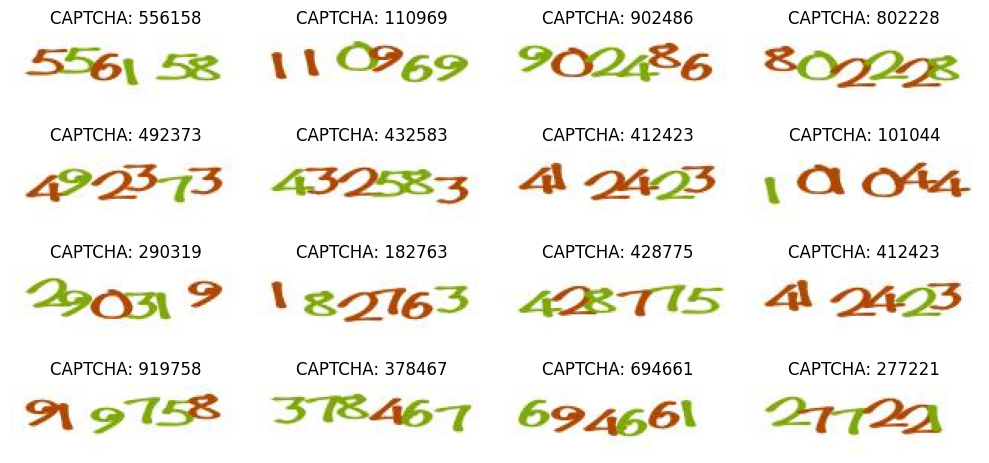

In [81]:
visualize_df(images_df)

# Model

In [82]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_length = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_length, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_length, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [83]:
input_layer = layers.Input(shape=(200, 50, 1), name="Input", dtype="float32")
label_layer = layers.Input(shape=(None,), name="Label", dtype="float32")

conv2_1 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_layer)
max2_1 = layers.MaxPooling2D(strides=(2, 2))(conv2_1)

conv2_2 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(max2_1)
max2_2 = layers.MaxPooling2D(strides=(2, 2))(conv2_2)

reshape_layer = layers.Reshape(target_shape=((200 // 4), (50 // 4) * 64))(max2_2)
dense_1 = layers.Dense(units=64, activation="relu")(reshape_layer)
drop_1 = layers.Dropout((0.2))(dense_1)

bilstm_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(drop_1)
bilstm_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(bilstm_1)

output_layer = layers.Dense(len(characters) + 1, activation="softmax", name="Output")(bilstm_2)

output = CTCLayer(name="ctc_loss")(label_layer, output_layer)

model = models.Model(inputs=[input_layer, label_layer], outputs=output, name="OCR")

In [84]:
model.compile(optimizer=optimizers.Adam())

In [85]:
model.summary()

Model: "OCR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 200, 50,   │        320 │ Input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 100, 25,   │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 100, 25,   │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 50, 12,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 50, 768)   │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50, 64)    │     49,216 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 64)    │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 50, 256)   │    197,632 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 50, 128)   │    164,352 │ bidirectional_2[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 50, 11)    │      1,419 │ bidirectional_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 50, 11)    │          0 │ Label[0][0],      │
│                     │                   │            │ Output[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 431,435 (1.65 MB)

 Trainable params: 431,435 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

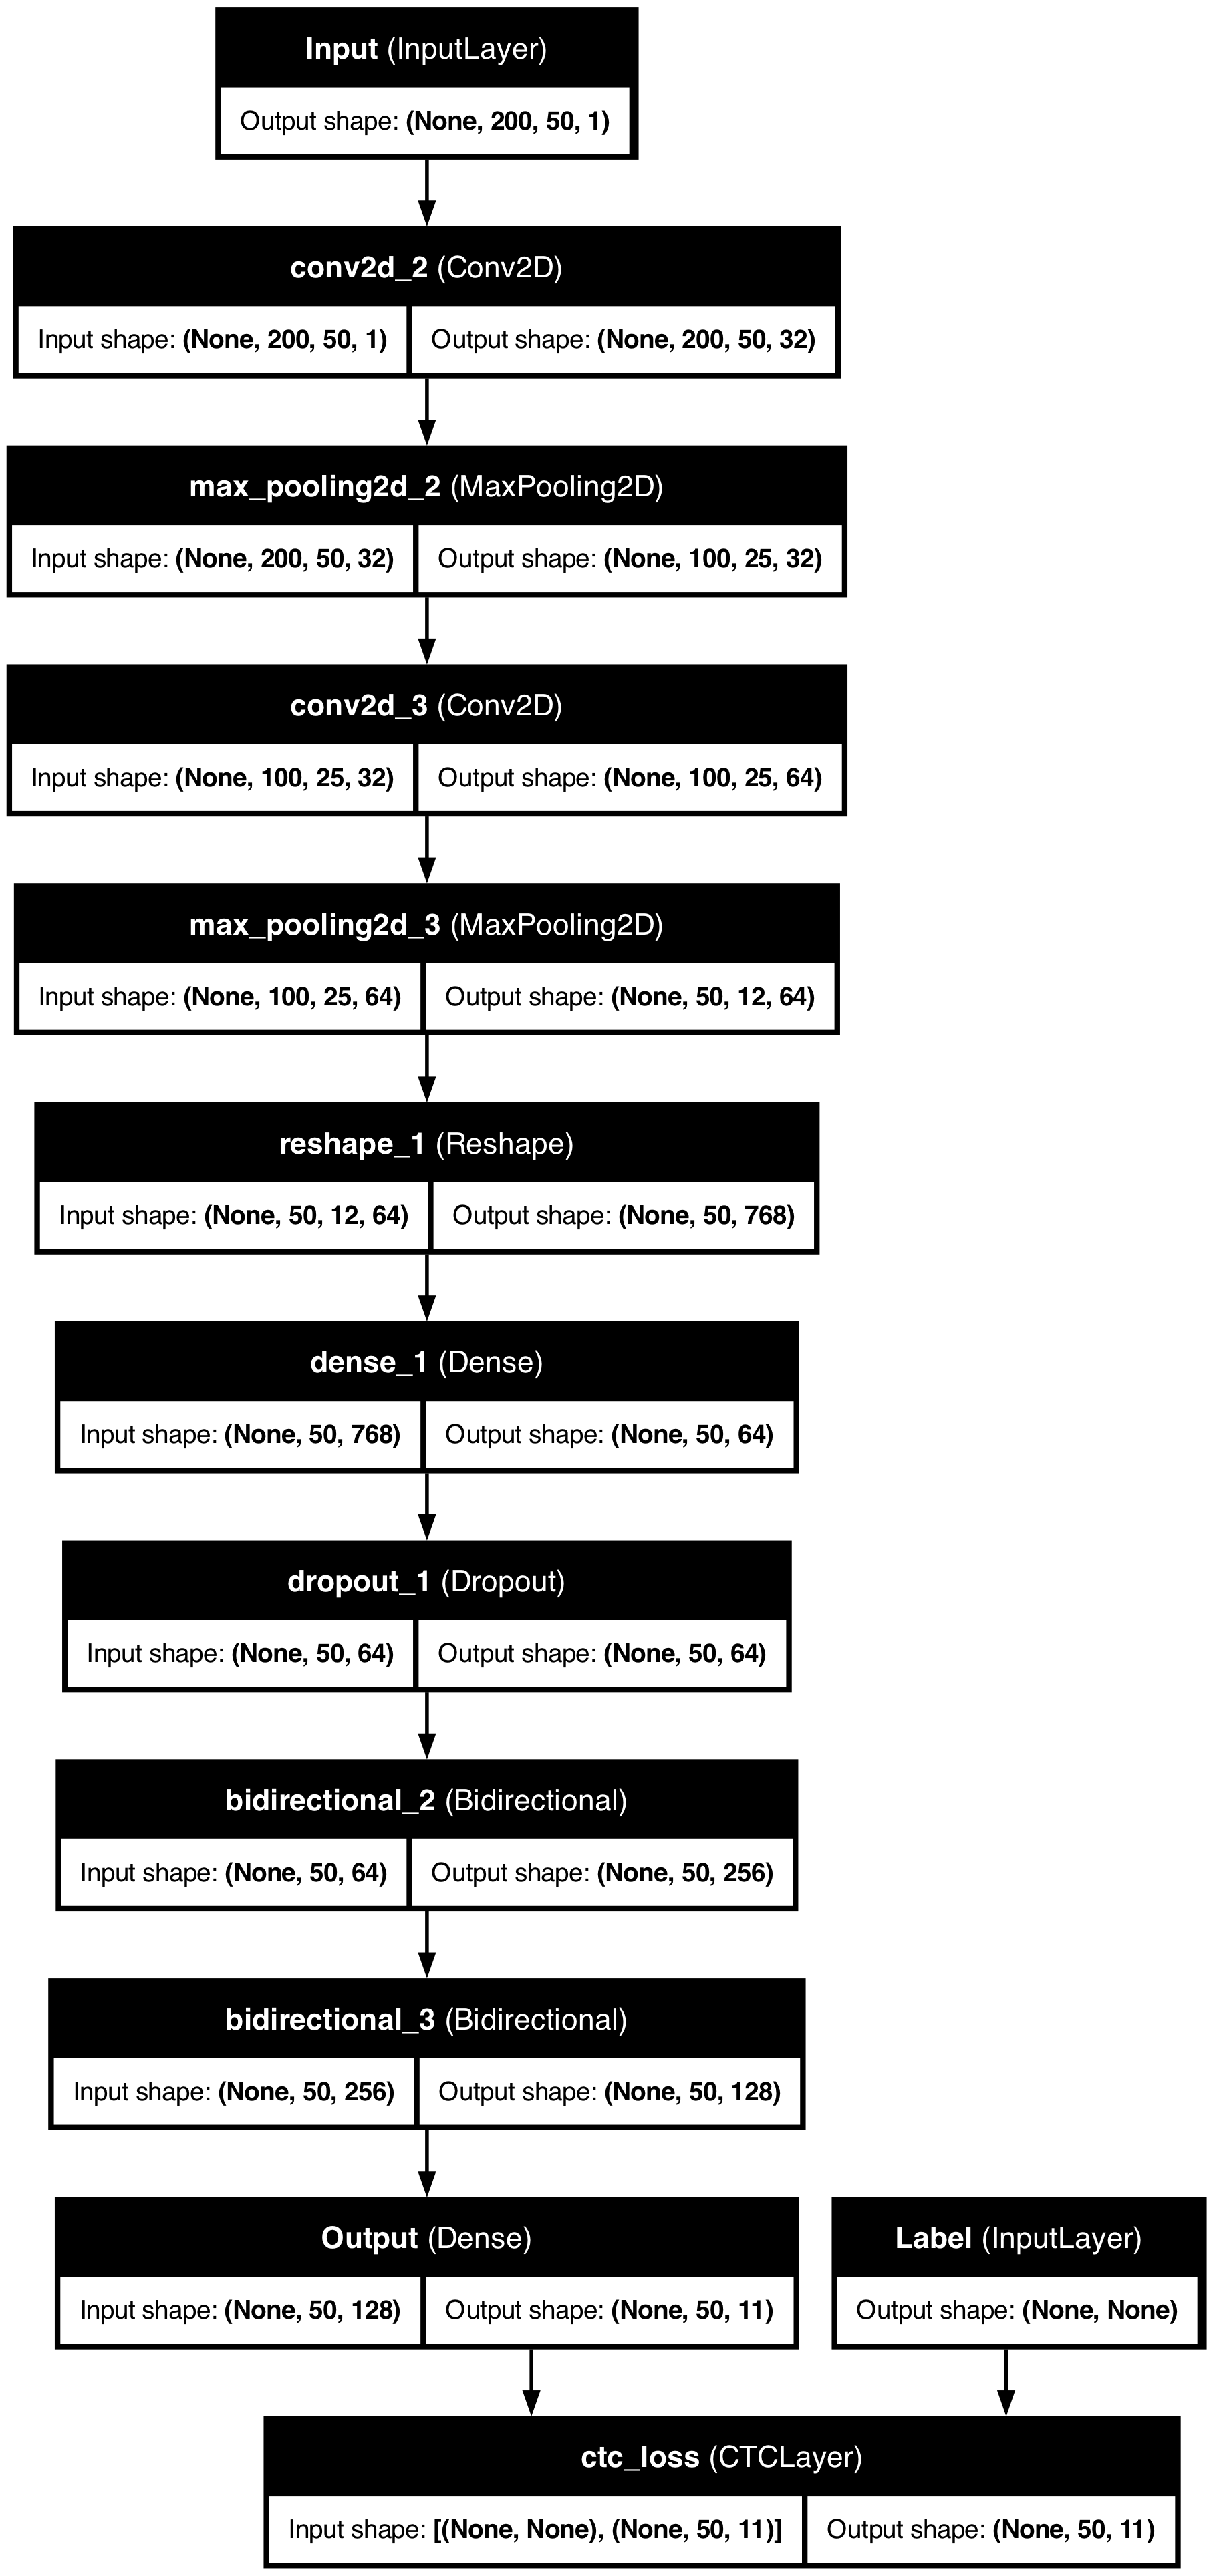

In [86]:
plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

# Train

In [87]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [88]:
history = model.fit(
    X_train_input,
    y_train_processed,
    validation_data=(X_test_input, y_test_processed),
    epochs=500,
    batch_size=32,
    #callbacks=[early_stopping]
)
model.save("captcha_mpets.keras")

Epoch 1/500
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - loss: 2093.9404

KeyboardInterrupt: 

# Results

In [ ]:
# from keras import models
# model = models.load_model("captcha_mpets.keras", custom_objects={"CTCLayer": CTCLayer})

In [ ]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend(["Обучение", "Валидация"])
plt.title("Кривая потерь")
plt.show()

# Test

In [ ]:
preds = model.predict(X_test_input)
input_length = np.ones(preds.shape[0]) * preds.shape[1]
results = ctc_decode(preds, input_length=input_length, greedy=True)[0][0][:, :6]
pred_texts = []
for result in results:
    res = tf.strings.reduce_join(num_to_char(result+1)).numpy().decode("utf-8")
    pred_texts.append(res)


In [89]:
# Загрузка изображения
image_path = "./mp/samples/440401.png"  # Замените на путь к вашему изображению
image = Image.open(image_path)

# Предобработка изображения
image = image.convert('L')  # Преобразование в оттенки серого
image = image.resize((50, 200))  #  # Преобразуем изображение в формат RGB
image_array = np.array(image)  # Преобразуем изображение в массив numpy
image_array = image_array / 255.0  # Нормализуем значения пикселей до диапазона [0, 1]

# Добавляем измерение для батча (если модель ожидает пакет изображений)
image_array = np.expand_dims(image_array, axis=0)

label_array = np.zeros((1, 6))

char_to_num = layers.StringLookup(
    vocabulary = list({'1', '2', '3', '4', '5', '6', '7', '8', '9', '0'}),
    num_oov_indices = 0,
    mask_token = None
)

num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

# Передача изображения в модель для предсказания
predictions = model.predict([image_array, label_array])
# Получение результата
sequence_length = [image_array.shape[2]]  # Предполагается, что изображение представлено как (batch_size, height, width, channels)

# Декодирование предсказаний
decoded_result, _ = tf.keras.backend.ctc_decode(predictions, input_length=sequence_length)

pred_texts = []
for result in decoded_result:
    res = tf.strings.reduce_join(num_to_char(result[:, :6] + 1)).numpy().decode("utf-8")
    pred_texts.append(res)

print(pred_texts)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
['[UNK][UNK][UNK][UNK][UNK][UNK]']


In [ ]:
pred_df = pd.DataFrame({
    "Путь до файла": X_test,
    "Ожидалось": y_test,
    "Результат": pred_texts,
    "Совпадение": [1 if y_test[i] == pred_texts[i] else 0 for i in range(len(y_test))]
})
print(X_test)

In [ ]:
pred_df.head(1000)

In [ ]:
pred_df.to_excel("preds.xlsx")

In [ ]:
def visualize_predictions(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            label = df.loc[a][["label"]].values[0]
            pred = df.loc[a][["pred"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"Ожидалось: {label}\nРезультат: {pred}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_predictions(pred_df)